In [1]:
# %%bash

# pip install gpflow gpy
# pip install xlrd openpyxl gpytorch

In [1]:
import numpy as np 
import pandas as pd

import os

import matplotlib.pyplot as plt

from IPython.display import display, HTML

from sklearn.preprocessing import MinMaxScaler

from functools import partial
import itertools

# import GPy

# import gpflow

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as tnf

import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

import gpytorch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [4]:
# %%bash

# pip install git+https://github.com/GPflow/GPflow.git@develop#egg=gpflow
# pip install gpflow
# --force-reinstall

In [5]:
# import gpflow
# import tensorflow as tf
# from gpflow.utilities import print_summary

## Load and plot

In [5]:
data_dir = "/mnt/beegfs/projects/power-conv/data/xls"
input_name = "cycle"; output_name = "vce"
print(os.listdir(data_dir))


['Cyclage SKIM306GD12E4 - Tref55C_DeltaT_110C.xlsx', 'Cyclage SKIM306GD12E4 - Tref55C_DeltaT_110Cbis.xlsx', 'Cyclage SKIM306GD12E4 - Tref55C_DeltaT_90C.xlsx', 'Cyclage SKIM306GD12E4 - Tref35C_DeltaT_90C.xlsx', 'Cyclage SKIM306GD12E4 - Tref35C_DeltaT_110C.xlsx', 'Cyclage SKIM306GD12E4 - Tref35C_DeltaT_70C.xlsx', 'Cyclage SKIM306GD12E4 - Tref55C_DeltaT_70C.xlsx']


In [6]:
def read_xls(datadir, specs):
    xlspath = f'{datadir}/Cyclage SKIM306GD12E4 - {specs}.xlsx'
    xls_data = pd.read_excel(xlspath, sheet_name=None, engine='openpyxl')
    return xls_data

def extract_series(module_data):
    selected_column_index = [np.where(module_data.iloc[2, :].values == "N° de cycle\n")[0][0],
                         np.where(module_data.iloc[2, :].values == "Vce corrigé à Tj0\n(V)")[0][0]
    ]
    selected_data = module_data.iloc[3:, selected_column_index].dropna()
    
#     input_name = "kcycle"; output_name = "vce"
    selected_data.columns=[input_name, output_name]
    
    return selected_data

def extract_data(xlsdata):
    extracted = {key:extract_series(value) \
                for key, value in xlsdata.items() if key.startswith('Rth Module')}
    return extracted

def dynamic_subplot(ncolumn, datadict, figsize=(24, 16), suptitle=""):
    nrow = (len(datadict) + 1) // ncolumn
    fig, axes = plt.subplots(nrow, ncolumn, figsize=figsize)
    axes = axes.flatten()
    
    for (modulename, moduledata), ax in zip(datadict.items(), axes):
        ax.scatter(moduledata[input_name], moduledata[output_name])
        ax.hlines(moduledata[output_name].iloc[0] * 1.05, xmin=0, xmax=moduledata[input_name].max(), 
            linestyles='--', label="1.05 Vce0", colors="red")
        ax.set_title(modulename)
        
        ax.set_ylabel(output_name)
        ax.set_xlabel(input_name)
        ax.legend()
        
    plt.suptitle(suptitle)
        
    return fig

In [7]:
specs = 'Tref35C_DeltaT_110C'
xls_data = read_xls(data_dir, specs)
# for sheet_name, df in data.items():
#     df.to_csv(f'{sheet_name}.csv')
# print(xls_data.keys())

extracted_data = extract_data(xls_data)
# filtered_data.keys()

# extracted_data = {key:extract_series(value) for key, value in filtered_data.items()}
print(extracted_data.keys())

dict_keys(['Rth Module 1L', 'Rth Module 1H', 'Rth Module 7L', 'Rth Module 7H', 'Rth Module 8L', 'Rth Module 8H', 'Rth Module 4L', 'Rth Module 4H', 'Rth Module 5L', 'Rth Module 5H', 'Rth Module 6L', 'Rth Module 6H'])


In [8]:
def check_preprocessing():
    random_module = np.random.choice(list(extracted_data.keys()))
    vce_column_index = np.where(xls_data[random_module].iloc[2, :].values == "Vce corrigé à Tj0\n(V)")[0][0]
    assert np.prod(extracted_data[random_module]["vce"] == xls_data[random_module].iloc[3:,vce_column_index].dropna()) == 1
    
    return random_module, vce_column_index

check_preprocessing()

('Rth Module 4L', 6)

In [45]:
def export_csv(specs, datadir, outputdir):
    savedir = os.path.join(outputdir, specs)
    os.makedirs(savedir, exist_ok=True)
    
    xls_data = read_xls(data_dir, specs)
    extracteddata = extract_data(xls_data)
    
    for modulename, dataframe in extracteddata.items():
        dataframe.to_csv(os.path.join(savedir, f"{specs}-{modulename}.csv"), index=False)
    
    return outputdir

In [46]:
all_specs = "Tref35C_DeltaT_70C Tref35C_DeltaT_90C Tref35C_DeltaT_110C Tref55C_DeltaT_70C Tref55C_DeltaT_90C Tref55C_DeltaT_110C Tref55C_DeltaT_110Cbis".split(" ")
for spec in all_specs:
    export_csv(spec, data_dir, "/mnt/beegfs/projects/power-conv/data/csv")

/mnt/beegfs/home/vu/miniconda3/envs/py3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


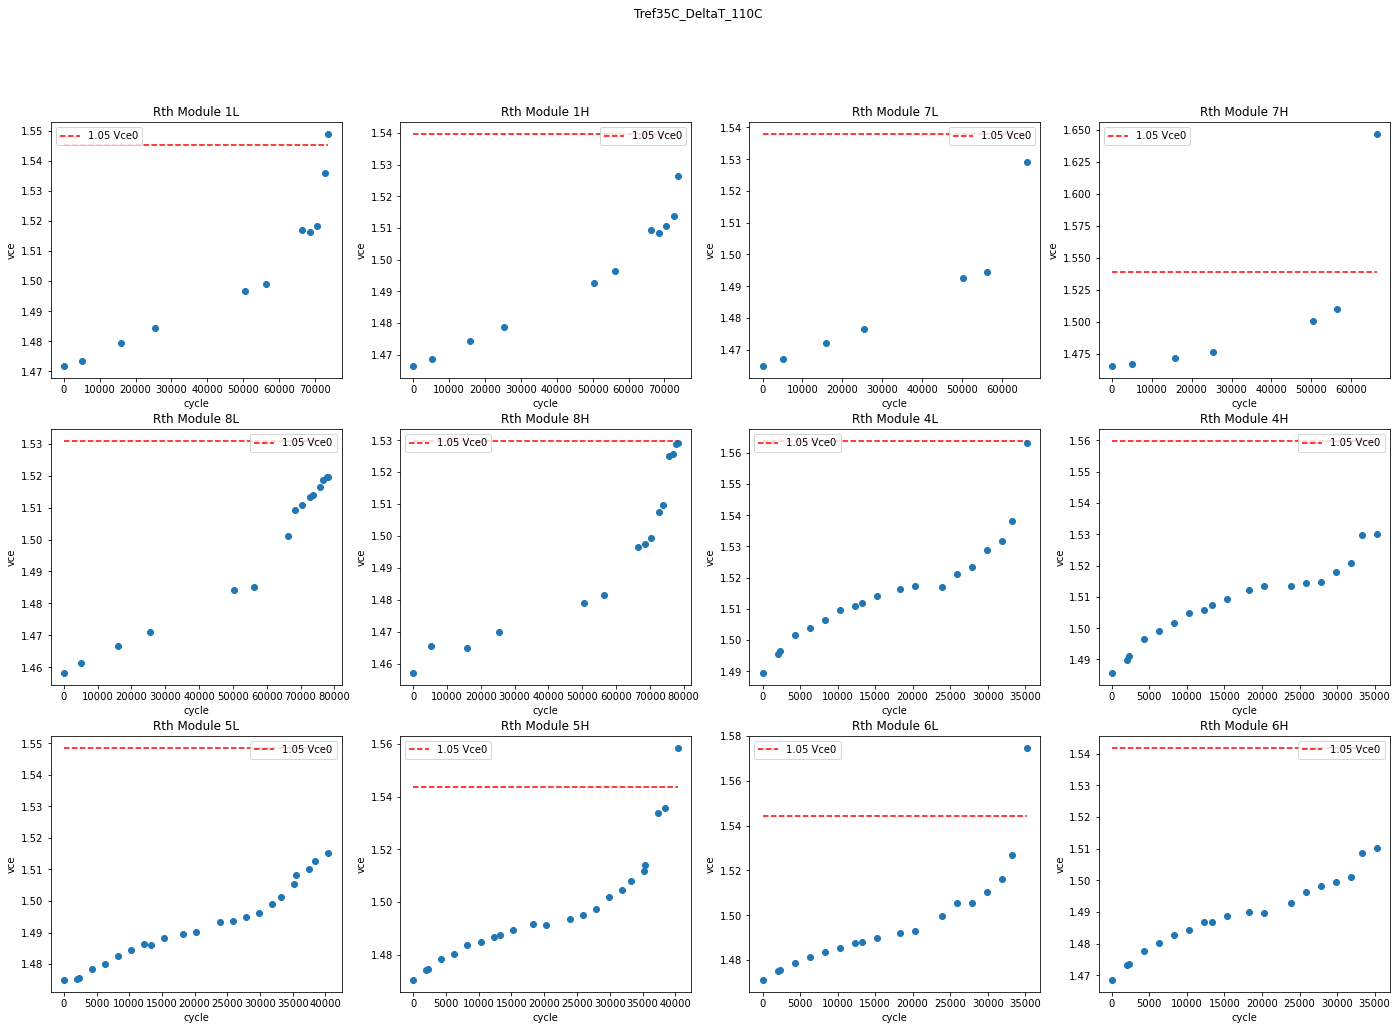

In [11]:
fig = dynamic_subplot(4, extracted_data, suptitle=specs)

In [12]:
# plt.figure(figsize=(20,6))
# plt.scatter(np.log(extracted_data[power_module][input_name].values.astype(float)), extracted_data[power_module][output_name])

In [13]:
def plot_length(datadict, title="", figsize=(20, 4)):
    fig = plt.figure(figsize=figsize)
    
#     for i, (modulename, moduledata() in enumerate(datadict.items()):
    plt.bar(datadict.keys(), list(map(lambda moduledata: len(moduledata), datadict.values())))
        
    plt.title(title)
    plt.ylabel("sequence length")
#     plt.xlabel(input_name)
#     plt.legend()
        
    return fig

def plot_single(datadict, title="", figsize=(20, 6), alpha=0.8):
    fig = plt.figure(figsize=figsize)
    
    for modulename, moduledata in datadict.items():
        plt.plot(moduledata[input_name], moduledata[output_name], label=modulename, marker="o", alpha=alpha)
        
    plt.title(title)
    plt.ylabel(output_name)
    plt.xlabel(input_name)
    plt.legend()
        
    return fig
        
# fig = plot_single(extracted_data, title=specs)        
# fig = plot_length(extracted_data, title=specs)

(<Figure size 1440x432 with 1 Axes>, <Figure size 1440x288 with 1 Axes>)

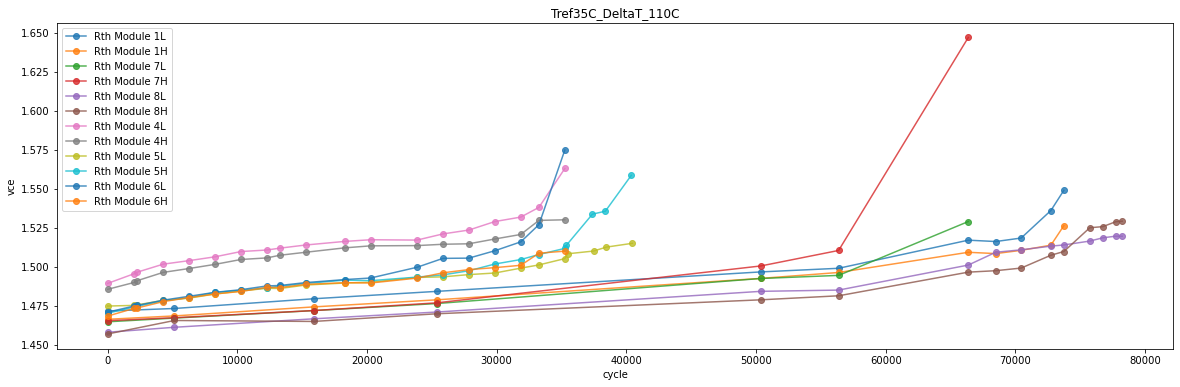

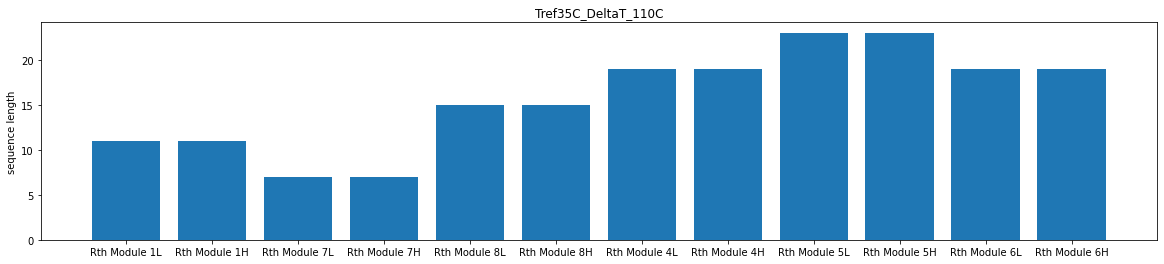

In [14]:
specs = 'Tref35C_DeltaT_110C'
xls_data = read_xls(data_dir, specs)
extracted_data = extract_data(xls_data)
plot_single(extracted_data, title=specs), plot_length(extracted_data, title=specs)

(<Figure size 1440x432 with 1 Axes>, <Figure size 1440x288 with 1 Axes>)

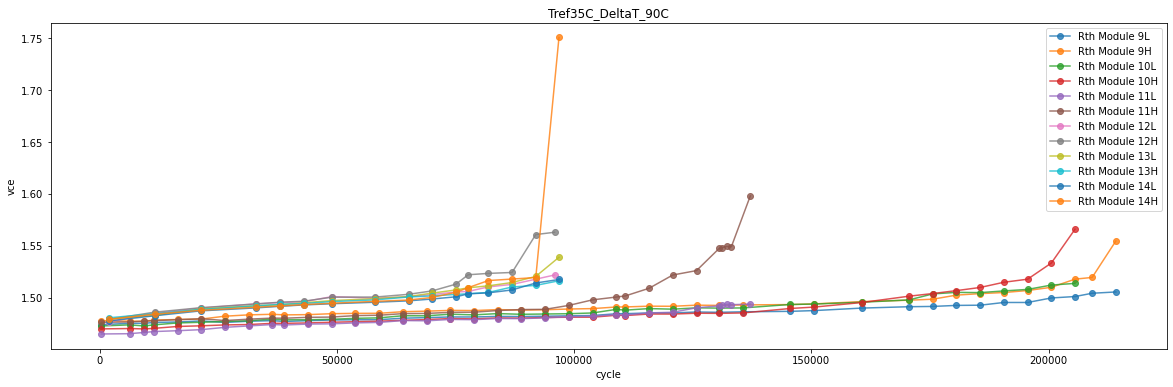

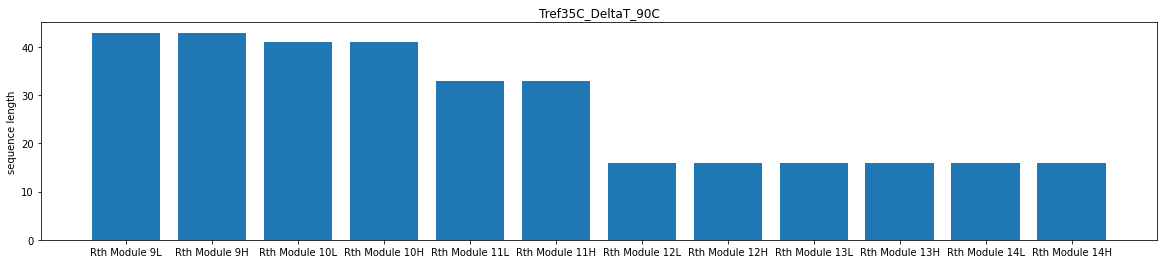

In [15]:
specs = 'Tref35C_DeltaT_90C'
xls_data = read_xls(data_dir, specs)
extracted_data = extract_data(xls_data)
plot_single(extracted_data, title=specs), plot_length(extracted_data, title=specs)

/mnt/beegfs/home/vu/miniconda3/envs/py3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(<Figure size 1440x432 with 1 Axes>, <Figure size 1440x288 with 1 Axes>)

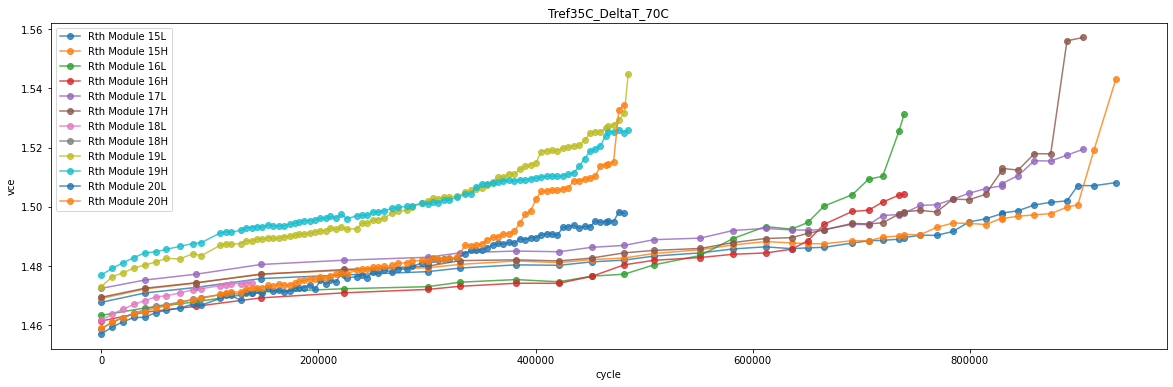

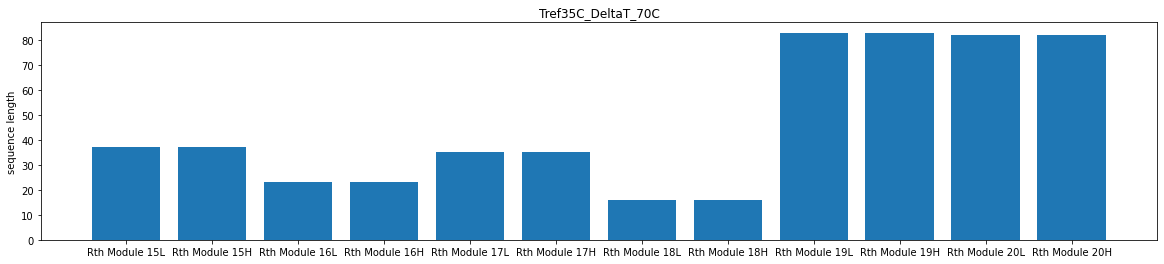

In [16]:
specs = 'Tref35C_DeltaT_70C'
xls_data = read_xls(data_dir, specs)
extracted_data = extract_data(xls_data)
plot_single(extracted_data, title=specs), plot_length(extracted_data, title=specs)

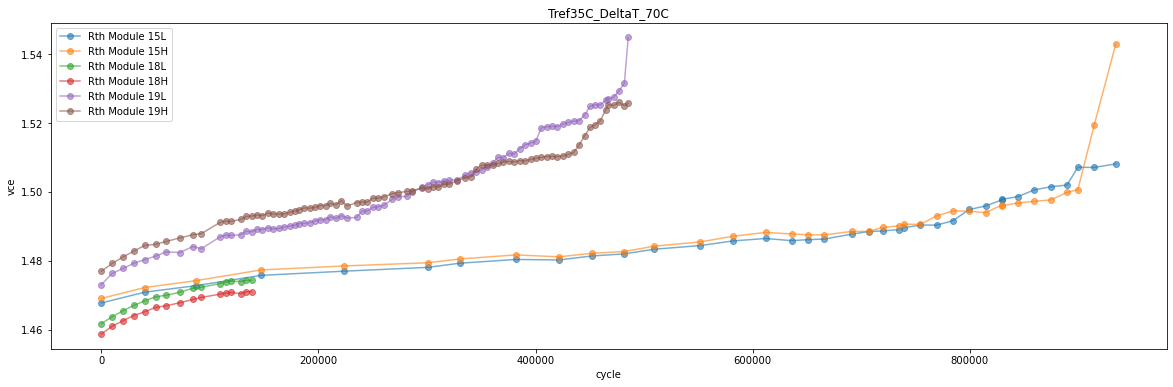

In [17]:
# def plot_module(datadict, modules, title=""):
#     fig = plt.figure(figsize=(20,6))
    
#     for module in modules:
# #         plt.scatter(datadict[module][input_name], datadict[module][output_name], label=module, alpha=0.6)
#         plt.plot(datadict[module][input_name], datadict[module][output_name], label=module, alpha=0.6, marker="o")

#     plt.ylabel(output_name)
#     plt.xlabel(input_name)
#     plt.legend()
#     plt.title(title)
    
#     return fig

# selected_modules = "Rth Module 19L ; Rth Module 19H ; Rth Module 20L ; Rth Module 20H ; Rth Module 18L ; Rth Module 18H".split(" ; ")
selected_modules = "Rth Module 19L ; Rth Module 19H ; Rth Module 18L ; Rth Module 18H ; Rth Module 15L ; Rth Module 15H".split(" ; ")
selected_data = {module: extracted_data[module] for module in extracted_data.keys() if module in selected_modules}
fig = plot_single(selected_data, specs, alpha=0.6)

## Preprocess

In [18]:
def get_preprocessor(original_data):
    scaler = MinMaxScaler()
    transformed = scaler.fit_transform(original_data.reshape(-1, 1))
    return transformed.squeeze(), scaler

def window_slide(sequence, inputlength, outputlength):
    indata = []
    outdata = []
    
    for i in range(len(sequence) - outputlength - inputlength + 1):
        inputend = i + inputlength
        indata.append(sequence[i : inputend])
        outdata.append(sequence[inputend: inputend + outputlength])
    
    return np.stack(indata), np.stack(outdata)

def train_valid_split(inputtensor, targettensor):
    trainend = 42
    traininput = inputtensor[:trainend]
    traintarget = targettensor[:trainend]
    validinput = inputtensor[trainend:]
    validtarget = targettensor[trainend:]
    
    return traininput, traintarget, validinput, validtarget

In [19]:
selected_module = "Rth Module 19L"
transformed_data, data_preprocessor = get_preprocessor(extracted_data[selected_module][output_name].values)

input_seq, target_seq = window_slide(transformed_data, inputlength=20, outputlength=1)

input_tensor = torch.from_numpy(input_seq.astype(float)).unsqueeze(-1).float()
target_tensor = torch.from_numpy(target_seq.astype(float)).float()

print(input_tensor.shape, target_tensor.shape, extracted_data[selected_module][output_name].shape)

train_input, train_target, valid_input, valid_target = train_valid_split(input_tensor, target_tensor)
print(train_input.shape, train_target.shape, valid_input.shape, valid_target.shape)

assert np.product(data_preprocessor.transform(extracted_data[selected_module][output_name][20:].values.reshape(-1, 1)) == target_seq) == 1

torch.Size([63, 20, 1]) torch.Size([63, 1]) (83,)
torch.Size([42, 20, 1]) torch.Size([42, 1]) torch.Size([21, 20, 1]) torch.Size([21, 1])


In [20]:
input_data = extracted_data[selected_module][input_name].values.astype(float)
target_data = extracted_data[selected_module][output_name].values.astype(float)

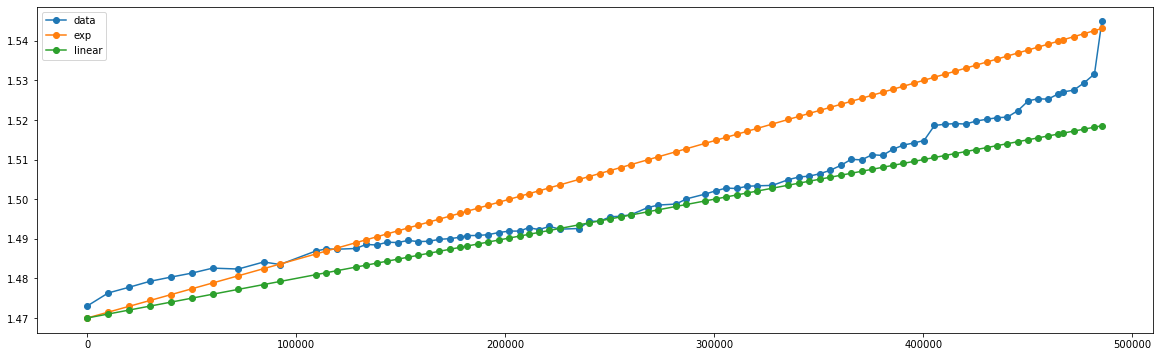

In [21]:
plt.figure(figsize=(20,6))
# xplot = np.arange(0, len(extracted_data[selected_module]))
xplot = extracted_data[selected_module][input_name].values.astype(float)
plt.plot(xplot, extracted_data[selected_module][output_name], marker="o", label="data")
plt.plot(xplot, 1.47 * np.exp(xplot * 1e-7), marker="o", label="exp")
plt.plot(xplot, 1.47 + 1e-7 * xplot, marker="o", label="linear")
plt.legend()

## RNN train

Inspired by:

https://www.kaggle.com/code/omershect/learning-pytorch-seq2seq-with-m5-data-set/notebook#Building-the-Seq2Seq-Model-

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/

https://curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/


In [21]:
class Encoder(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
    def forward(self, indata):
#         batch size x hidden size
#         indata = indata.reshape(indata.size(0), self.seq_len, self.hidden_size)
#         hidden0 = torch.zeros(indata.size(0), self.hidden_size, device=device)
        outdata, hidden = self.gru(indata)
        
        return outdata, hidden
    
class Decoder(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, output_size)
        
    def forward(self, indata, hidden):
        outdata, hidden = self.gru(indata, hidden)
        outdata = self.head(outdata)
        
        return outdata, hidden
        
class Seq2Seq(nn.Module):
    def __init__(self, input_len, output_len, input_size, hidden_size, output_size):
        super().__init__()
        self.input_len = input_len
        self.output_len = output_len
        
        self.input_size = input_size        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = Encoder(input_len, input_size, hidden_size)
        self.decoder = Decoder(output_len, input_size, hidden_size, output_size)
        
    def forward(self, indata):
        encode_out, encode_hidden = self.encoder(indata)
        
        predictions = []
        previous_prediction = indata[:, -self.output_len:, :]
        decode_hidden = encode_hidden
        print(f"{previous_prediction.shape=}, {decode_hidden.shape=}")
        
        for i in range(self.output_len):
            decode_out, decode_hidden = self.decoder(previous_prediction, decode_hidden)
            predictions.append(decode_out)
        
        predictions = torch.stack(predictions)
        print(f"{predictions.shape=}")
        return predictions
    
    
model = Seq2Seq(input_len=4, output_len=3, 
                input_size=1, hidden_size=8, output_size=1)
# batch size x input length x input size
model(torch.rand(2, 4, 1))[0]

previous_prediction.shape=torch.Size([2, 3, 1]), decode_hidden.shape=torch.Size([1, 2, 8])
predictions.shape=torch.Size([3, 2, 3, 1])


tensor([[[-0.1256],
         [-0.1345],
         [-0.1498]],

        [[-0.1332],
         [-0.1579],
         [-0.1739]]], grad_fn=<SelectBackward>)

In [22]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
#         self.seq_len = seq_len
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, output_size)
        
    def forward(self, indata):
#         batch size x hidden size
#         indata = indata.reshape(indata.size(0), self.seq_len, self.hidden_size)
#         hidden0 = torch.zeros(indata.size(0), self.hidden_size, device=device)
        outdata, hidden = self.gru(indata)
#         print(f"{outdata.shape=}, {hidden.shape=}")
#         output = batchsize x inputlength x hiddensize
        outdata = self.head(outdata[:,-1,:])
#         print(f"{outdata.shape=}, {hidden.shape=}")
        return outdata, hidden
    
model = GRUModel(input_size=1, hidden_size=8, output_size=1)
# batch size x input length x input size
model(torch.rand(2, 4, 1))[0]

tensor([[0.2617],
        [0.2607]], grad_fn=<AddmmBackward>)

In [36]:
def train_model(model, traininput, trainlabel, epochs=5):
    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    losses = []
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        outputdata = model(traininput)
        predictions = outputdata[0]
#         print(f"{predictions.shape=}, {trainlabel.shape=}")
        loss = tnf.mse_loss(predictions, trainlabel)
        
        loss.backward()
        optim.step()        
        losses.append(loss.detach().item())
        
        if epochs < 10 or epoch % (epochs//10) == 0:
            print(f"Epoch {epoch+1} loss = {loss}")
            
    return losses

# model = Seq2Seq(input_len=20, output_len=10, 
#                 input_size=20, hidden_size=2, output_size=1).to(device)
model = GRUModel(input_size=1, hidden_size=4, output_size=1).to(device)
train_losses = train_model(model, train_input.to(device), train_target.to(device), epochs=1000)


Epoch 1 loss = 0.19402043521404266
Epoch 101 loss = 0.002117130672559142
Epoch 201 loss = 6.124203355284408e-05
Epoch 301 loss = 6.031342491041869e-05
Epoch 401 loss = 5.995174069539644e-05
Epoch 501 loss = 5.96365389355924e-05
Epoch 601 loss = 5.937003152212128e-05
Epoch 701 loss = 5.91449934290722e-05
Epoch 801 loss = 5.895285357837565e-05
Epoch 901 loss = 5.8787420130101964e-05


## RNN predict

In [37]:
def predict_one_step(model, inputdata, targetdata):
    model.eval()
    
    with torch.no_grad():
        outputdata = model(inputdata)
        predictions = outputdata[0]
        loss = tnf.mse_loss(predictions, targetdata).detach().item()
        
    return predictions.detach().cpu(), loss

def predict_multi_step(model, last_input, nstep=10):
    model.eval()
    previous_output = last_input
    predictions = []
    
    for step in range(nstep):
        with torch.no_grad():
            outputdata = model(previous_output)
            prediction = outputdata[0]
            predictions.append(prediction.detach().cpu())
#             print(f"{previous_output=}")
            previous_output = torch.hstack((previous_output[:, 1:, :], prediction.reshape(1, -1, 1)))
#             print(f"{previous_output.shape=} {prediction.shape=}")

#     print(predictions)
    return torch.cat(predictions)



In [38]:
train_predictions, train_loss = predict_one_step(model, train_input.to(device), train_target.to(device))
print(train_predictions.shape, train_loss)

valid_predictions, valid_loss = predict_one_step(model, valid_input.to(device), valid_target.to(device))
print(valid_predictions.shape, valid_loss)

torch.Size([42, 1]) 5.864396007382311e-05
torch.Size([21, 1]) 0.0031233185436576605


In [39]:
def inverse_preproces(predictions, preprocessor=data_preprocessor):
    return preprocessor.inverse_transform(predictions.reshape(-1, 1)).squeeze()


In [40]:
def plot_prediction_target(target, train_prediction, test_prediction, title=""):
    prediction = np.concatenate((inverse_preproces(train_prediction), inverse_preproces(test_prediction)))
    
    fig = plt.figure(figsize=(16,4))
    plt.plot(inverse_preproces(target), label="target")
    plt.plot(prediction, label="prediction")
    
    plt.axvline(x=len(train_prediction), color='black', ls='--',  label='train end')
    plt.legend()
    plt.title(title)
    plt.ylabel("Vce")
    plt.xlabel("timestep")
    
    return fig


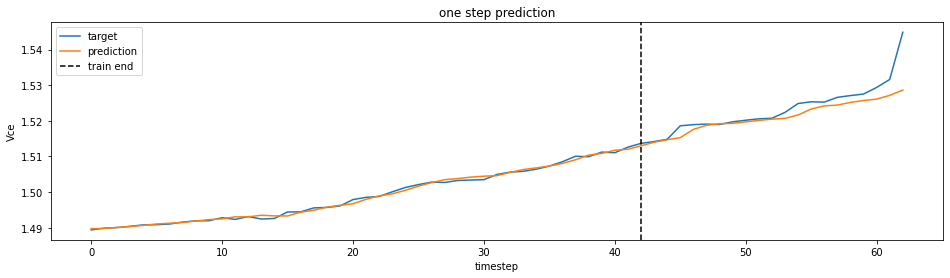

In [41]:
fig = plot_prediction_target(target_seq, train_predictions, valid_predictions, title="one step prediction")

# fig = plot_prediction_target(inverse_preproces(target_seq),
#     np.concatenate((inverse_preproces(train_predictions), inverse_preproces(valid_predictions))),
#     title="one step prediction")

# fig = plot_prediction_target(data_preprocessor.transform(extracted_data["Rth Module 19L"][output_name][20:].values.reshape(-1, 1)),
#     np.concatenate((train_predictions, valid_predictions)),
#     title="one step prediction")

In [29]:
train_input[-1].reshape(1, -1, 1)

tensor([[[0.3546],
         [0.3582],
         [0.3763],
         [0.3932],
         [0.4045],
         [0.4142],
         [0.4128],
         [0.4206],
         [0.4223],
         [0.4237],
         [0.4441],
         [0.4532],
         [0.4563],
         [0.4646],
         [0.4769],
         [0.4939],
         [0.5153],
         [0.5134],
         [0.5315],
         [0.5291]]])

torch.Size([40, 1])


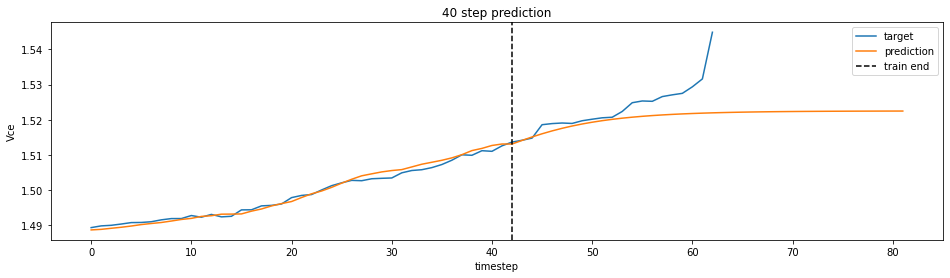

In [229]:
multistep_predictions = predict_multi_step(model, train_input[-1].reshape(1, -1, 1).to(device), nstep=40)
print(multistep_predictions.shape)

fig = plot_prediction_target(target_seq, train_predictions, multistep_predictions, title="40 step prediction")

# fig = plot_prediction_target(inverse_preproces(target_seq),
#     np.concatenate((inverse_preproces(train_predictions), inverse_preproces(multistep_predictions))),
#     title="40 step prediction")


## Tensorflow Probability Gaussian Process

adapted from 

https://peterroelants.github.io/posts/gaussian-process-kernel-fitting/

In [21]:
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
#     https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/main/notebooks/gaussian_process/monthly_in_situ_co2_mlo.csv
    '/mnt/beegfs/projects/power-conv/data/maunaloa-co2.csv', 
    header=3, # Data starts here
    skiprows=[4, 5], # Headers consist of multiple rows
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64
)

# Drop missing values
co2_df.dropna(inplace=True)
# Remove whitespace from column names
co2_df.rename(columns=lambda x: x.strip(), inplace=True)

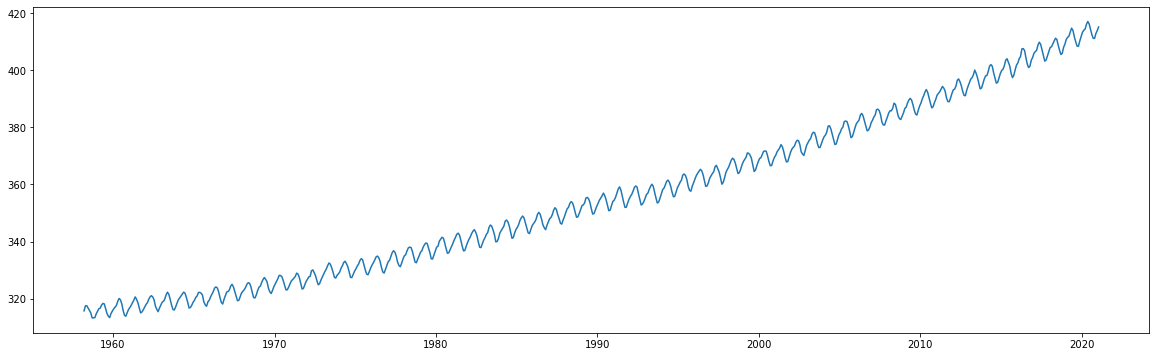

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(co2_df["Date"], co2_df["CO2"])

In [29]:
# Split the data into observed and to predict
date_split_predict = 2010
df_observed = co2_df[co2_df.Date < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Date >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
133 measurements in the test set


In [33]:
# Define mean function which is the means of observations
observations_mean = tf.constant(
    [np.mean(df_observed.CO2.values)], dtype=tf.float64)
mean_fn = lambda _: observations_mean

In [36]:
# Define the kernel with trainable parameters. 
# Note we transform some of the trainable variables to ensure
#  they stay positive.

# Use float64 because this means that the kernel matrix will have 
#  less numerical issues when computing the Cholesky decomposition

# Constrain to make sure certain parameters are strictly positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

# Smooth kernel hyperparameters
smooth_amplitude = tfp.util.TransformedVariable(
    initial_value=10., bijector=constrain_positive, dtype=np.float64,
    name='smooth_amplitude')
smooth_length_scale = tfp.util.TransformedVariable(
    initial_value=10., bijector=constrain_positive, dtype=np.float64,
    name='smooth_length_scale')
# Smooth kernel
smooth_kernel = tfk.ExponentiatedQuadratic(
    amplitude=smooth_amplitude, 
    length_scale=smooth_length_scale)

# Local periodic kernel hyperparameters
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=5.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_period')
periodic_local_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_local_length_scale')
# Local periodic kernel
local_periodic_kernel = (
    tfk.ExpSinSquared(
        amplitude=periodic_amplitude, 
        length_scale=periodic_length_scale,
        period=periodic_period) * 
    tfk.ExponentiatedQuadratic(
        length_scale=periodic_local_length_scale))

# Short-medium term irregularities kernel hyperparameters
irregular_amplitude = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_amplitude')
irregular_length_scale = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_length_scale')
irregular_scale_mixture = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_scale_mixture')
# Short-medium term irregularities kernel
irregular_kernel = tfk.RationalQuadratic(
    amplitude=irregular_amplitude,
    length_scale=irregular_length_scale,
    scale_mixture_rate=irregular_scale_mixture)

# Noise variance of observations
# Start out with a medium-to high noise
observation_noise_variance = tfp.util.TransformedVariable(
    initial_value=1, bijector=constrain_positive, dtype=np.float64,
    name='observation_noise_variance')

trainable_variables = [v.variables[0] for v in [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]]

In [37]:
# Sum all kernels to single kernel containing all characteristics
kernel = (smooth_kernel + local_periodic_kernel + irregular_kernel)

In [38]:
# Define mini-batch data iterator
batch_size = 128

batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (df_observed.Date.values.reshape(-1, 1), df_observed.CO2.values))
    .shuffle(buffer_size=len(df_observed))
    .repeat(count=None)
    .batch(batch_size)
)

In [39]:
# Use tf.function for more efficient function evaluation
@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

In [44]:
# Fit hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
batch_nlls = []  # Batch NLL for plotting
full_ll = []  # Full data NLL for plotting
nb_iterations = 10001
for i, (index_points_batch, observations_batch) in enumerate(itertools.islice(batched_dataset, nb_iterations)):
    # Run optimization for single batch
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    # Evaluate on all observations
    if i % 100 == 0:
        # Evaluate on all observed data
        ll = gp_loss_fn(
            index_points=df_observed.Date.values.reshape(-1, 1),
            observations=df_observed.CO2.values)
        full_ll.append((i, ll.numpy()))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


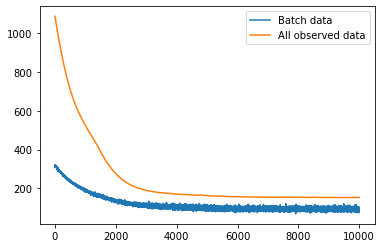

In [46]:
# plt.plot(*zip(*batch_nlls), label='Batch data')
# plt.plot(*zip(*full_ll), label='All observed data')
# plt.legend()

In [49]:

# Show values of parameters found
variables = [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]

data = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
df_variables = pd.DataFrame(
    data, columns=['Hyperparameters', 'Value'])
display(HTML(df_variables.to_html(
    index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters,Value
smooth_amplitude,107.67362265025989
smooth_length_scale,90.19950391356679
periodic_amplitude,3.068164812642239
periodic_length_scale,1.6638219230780935
periodic_period,0.9996923821116793
periodic_local_length_scale,109.00209209385386
irregular_amplitude,1.0018477011491593
irregular_length_scale,1.360299027524623
irregular_scale_mixture,0.10866244506756745
observation_noise_variance,0.05301544066306161


In [50]:
gp_posterior_predict = tfd.GaussianProcessRegressionModel(
    mean_fn=mean_fn,
    kernel=kernel,
    index_points=df_predict.Date.values.reshape(-1, 1),
    observation_index_points=df_observed.Date.values.reshape(-1, 1),
    observations=df_observed.CO2.values,
    observation_noise_variance=observation_noise_variance)

# Posterior mean and standard deviation
posterior_mean_predict = gp_posterior_predict.mean()
posterior_std_predict = gp_posterior_predict.stddev()

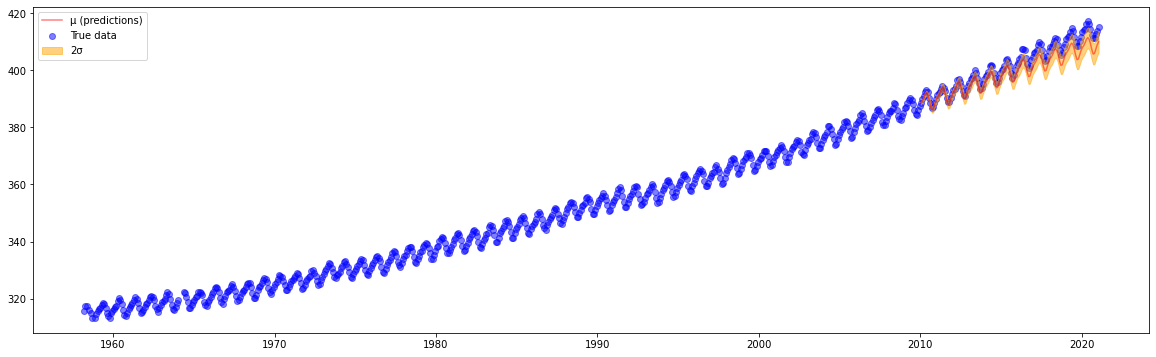

In [67]:

# Plot posterior predictions

# Get posterior predictions
μ = posterior_mean_predict.numpy()
σ = posterior_std_predict.numpy()

# Prediction interval
band_x = np.append(
    df_predict.Date.values, df_predict.Date.values[::-1])
band_y = np.append(
    (μ + 2*σ), (μ - 2*σ)[::-1])

plt.figure(figsize=(20, 6))
plt.scatter(co2_df.Date, co2_df.CO2, label='True data', alpha=0.5, c='blue')
plt.plot(df_predict.Date.values, μ, label='μ (predictions)', alpha=0.5, c='red')

plt.fill_between(df_predict.Date.values, μ - 2*σ, μ + 2*σ, alpha=0.5, label='2σ', color='orange')

plt.legend()

In [56]:
μ.shape, σ.shape

((133,), (133,))

## gpytorch

gpytorch adapted from \
https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb

In [23]:
all_xtensor = torch.tensor(extracted_data[selected_module][input_name].values.astype(float)).float()
all_ytensor = torch.tensor(extracted_data[selected_module][output_name].values.astype(float)).float()

train_x = all_xtensor[:60]
train_y = all_ytensor[:60]

In [69]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.LinearMean(input_size=1)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood).float()

In [70]:
print(model.state_dict())

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(1.0000e-04)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.weights', tensor([[0.0903]])), ('mean_module.bias', tensor([1.0162])), ('covar_module.raw_outputscale', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound', tensor(inf)), ('covar_module.raw_outputscale_constraint.lower_bound', tensor(0.)), ('covar_module.raw_outputscale_constraint.upper_bound', tensor(inf))])


/mnt/beegfs/home/vu/miniconda3/envs/py3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


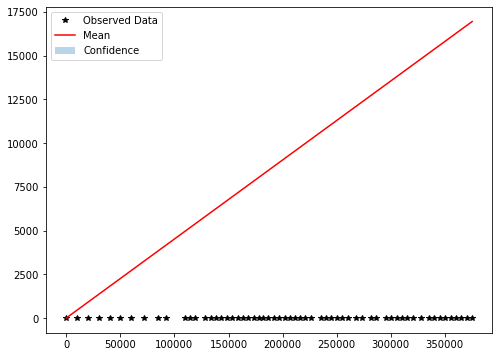

In [71]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    test_x = train_x
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
#     ax.set_ylim([1.4, 1.6])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [76]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

training_iter = 1000
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=1e-1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    
    loss.backward()
    optimizer.step()
    
    if (i%(training_iter//10) == 0) or (i+1 == training_iter):
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    

Iter 1/1000 - Loss: 15377406976.000   lengthscale: 0.693   noise: 0.744
Iter 101/1000 - Loss: 2169.095   lengthscale: 0.693   noise: 1.669
Iter 201/1000 - Loss: 5.986   lengthscale: 0.693   noise: 1.670
Iter 301/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 401/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 501/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 601/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 701/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 801/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 901/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670
Iter 1000/1000 - Loss: 1.532   lengthscale: 0.693   noise: 1.670


In [77]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = all_xtensor
    observed_pred = likelihood(model(test_x))

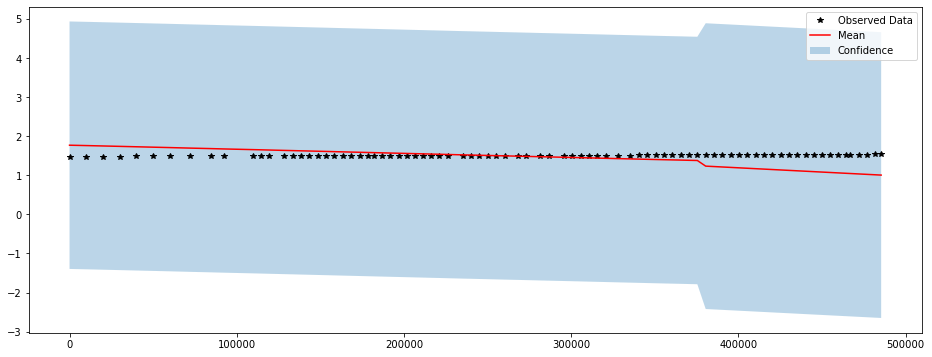

In [78]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(16, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(all_xtensor.numpy(), all_ytensor.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
#     ax.set_ylim([1.45,1.55])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## sklearn gaussian process

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import sklearn.gaussian_process as sklgp

In [41]:
all_input = input_data.reshape(-1, 1)
all_target = target_data.reshape(-1, 1)

X_train = all_input[:70]
y_train = all_target[:70]

In [89]:

kernel = 1 * RBF(length_scale=10, length_scale_bounds=(1e-3, 1e3))
# kernel = sklgp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * sklgp.kernels.RBF(1.0, (1e-3, 1e3))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9)

In [92]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)


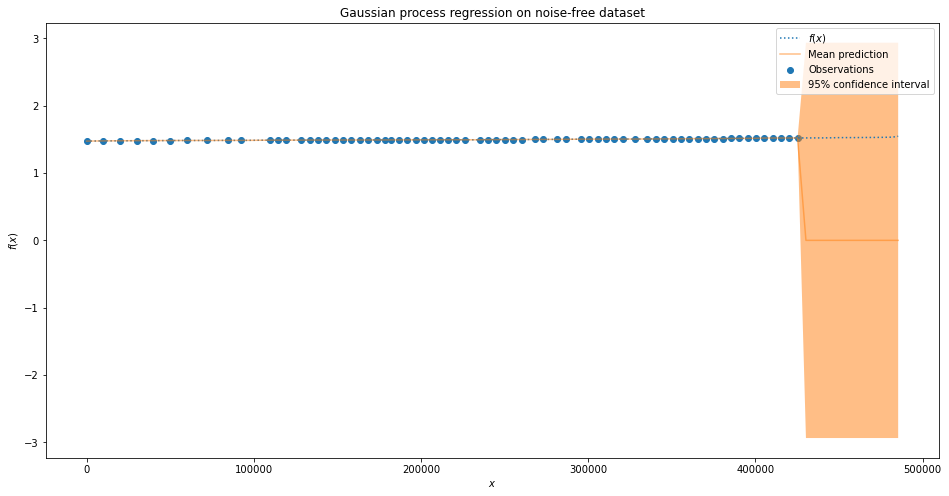

In [95]:

plt.figure(figsize=(16,8))
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction", alpha=0.5)
plt.fill_between(
    X.ravel(),
    mean_prediction.reshape(-1) - 1.96 * std_prediction,
    mean_prediction.reshape(-1) + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
# plt.ylim(1.46, 1.54)
_ = plt.title("Gaussian process regression on noise-free dataset")

## Quantile regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models[f"q{alpha:1.2f}"] = gbr.fit(X_train, y_train.ravel())

In [34]:
xx = all_input

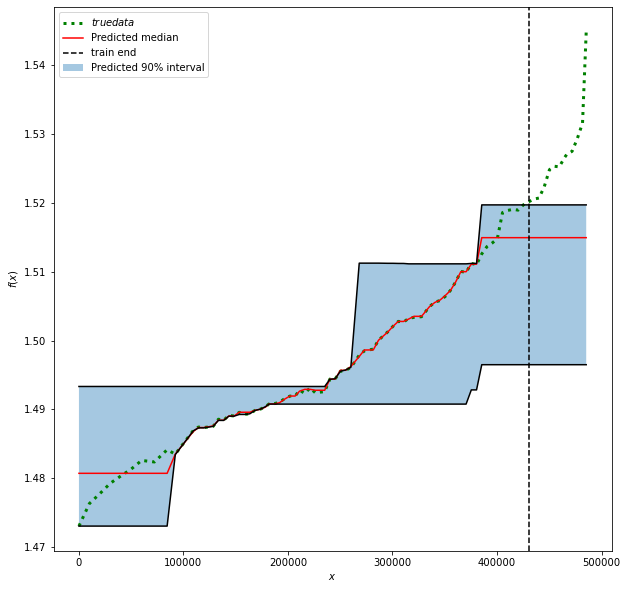

In [42]:
# y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q0.05"].predict(xx)
y_upper = all_models["q0.95"].predict(xx)
y_med = all_models["q0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(all_input, all_target, "g:", linewidth=3, label=r"$true data$")
# plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
# plt.plot(xx, y_pred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
plt.axvline(x=all_input[len(y_train)], color='black', ls='--',  label='train end')

plt.legend(loc="upper left")
plt.show()

## gpflow

gpflow adapted from \
https://github.com/jwangjie/Gaussian-Processes-Regression-Tutorial

In [ ]:
k = gpflow.kernels.RBF()
print_summary(k)

In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

In [ ]:
m.likelihood.variance.assign(0.01)  
m.kernel.lengthscales.assign(0.3)

In [ ]:
## generate test points for prediction
# xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)
xx = train_x

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 20)  # shape (10, 100, 1)

plt.figure(figsize=(12, 6))

plt.plot(X, Y, "k+", markersize=20, markeredgewidth=2)
plt.plot(xx, mean, "r-", lw=3)

plt.legend(['Observed data points', 'Estimated mean function'], prop={'size': 18})

plt.fill_between(xx[:,0], mean[:,0] - 3*np.sqrt(var[:,0]), mean[:,0] + 3*np.sqrt(var[:,0]), color="C0", alpha=0.15)

plt.plot(xx, samples[:, :, 0].numpy().T, linewidth=0.6)

_ = plt.xlim(-0.1, 1.1)

plt.savefig('regression_gpflow')

In [ ]:
opt = gpflow.optimizers.Scipy()

m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
m.likelihood.variance.assign(0.01)  
m.kernel.lengthscales.assign(0.3)

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)


In [ ]:
## generate test points for prediction
# xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)
xx = train_x

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 30)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "k+", markersize=20, markeredgewidth=2)
plt.plot(xx, mean, "r-", lw=3)

plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.15,
)
plt.plot(xx, samples[:, :, 0].numpy().T, linewidth=0.6)
_ = plt.xlim(-0.1, 1.1)

plt.savefig('regression')

## GPy

GPy adapted from \
https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb

In [ ]:
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05



In [ ]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(train_x.unsqueeze(-1).numpy(), train_y.unsqueeze(-1).numpy(), kernel)

display(m)

In [ ]:
fig = m.plot()
print(fig)
# GPy.plotting.change_plotting_library('matplotlib')
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook')
fig

In [ ]:
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

In [ ]:
display(m)
fig = m.plot()
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')
fig